# Learning Auto-Punctuation by Reading Engadget Articles  [[Repo]](https://github.com/episodeyang/deep-auto-punctuation#learning-auto-punctuation-by-reading-engadget-articles)

[[DOI]](https://zenodo.org/badge/latestdoi/86387963)


## Overview

This project trains a bi-directional GRU to learn how to automatically punctuate a sentence by reading it character by character. The set of operation it learns include:
```
capitalization: <cap>
         comma:  ,
        period:  .
   dollar sign:  $
     semicolon:  ;
         colon:  :
  single quote:  '
  double quote:  "
  no operation: <nop>
```

### Performance

24 epochs takes about 8 hours on a i7 PC. Performance at 24 and 48 epochs are similar with slight improvements. Here is the performance at 48 epoch, for detailed record refer to the cell output at the end of this notebook.

```
    Test P/R  Epoch 48 Batch 380
    =================================
    Key: <nop>	Prec:  97.1%	Recall:  98.0%	F-Score:  97.6%
    Key: <cap>	Prec:  73.2%	Recall:  58.9%	F-Score:  65.3%
    Key:   ,	Prec:  35.7%	Recall:  32.2%	F-Score:  33.9%
    Key:   .	Prec:  45.0%	Recall:  39.7%	F-Score:  42.2%
    Key:   '	Prec:  81.7%	Recall:  83.4%	F-Score:  82.5%
    Key:   :	Prec:  12.1%	Recall:  10.8%	F-Score:  11.4%
    Key:   "	Prec:  25.2%	Recall:  44.8%	F-Score:  32.3%
    Key:   $	Prec:  51.4%	Recall:  87.8%	F-Score:  64.9%
    Key:   ;	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
    Key:   ?	Prec:   5.6%	Recall:   4.8%	F-Score:   5.1%
    Key:   !	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
```


### Requirements

```
pytorch numpy matplotlib tqdm bs4
```

## Model Setup and Considerations

The initial setup I began with was a single uni-direction GRU, with input domain [A-z0-9] and output domain of the ops listed above. My hope at that time was to simply train the RNN to learn correcponding operations. A few things jumped out during the experiment:

1. **Use bi-directional GRU.** with the uni-direction GRU, the network quickly learned capitalization of terms, but it had difficulties with single quote. In words like "I'm", "won't", there are simply too much ambiguity from reading only the forward part of the word. The network didn't have enough information to properly infer such punctuations.
    
    So I decided to change the uni-direction GRU to bi-direction GRU. The result is much better prediction for single quotes in concatenations.

    the network is still training, but the precision and recall of single quote is nowt close to 80%.
    
    This use of bi-directional GRU is standard in NLP processes. But it is nice to experience first-hand the difference in performance and training.
    
    A side effect of this switch is that the network now runs almost 2x slower. This leads to the next item in this list:
2. **Use the smallest model possible.** At the very begining, my input embeding was borrowed from the Shakespeare model, so the input space include both capital alphabet as well as lower-case ones. What I didn't realize was that I didn't need the capital cases because all inputs were lower-case. 
    
    So when the training became painfully slow after I switch to bi-directional GRU, I looked for ways to make the training faster. A look at the input embeding made it obvious that half of the embedding space wasn't needed. 

    Removing the lower case bases made the traing around 3x faster. This is a rough estimate since I also decided to redownload the data set at the same time on the same machine.
    
3. **Text formatting**. Proper formating of input text crawed from Engadget.com was crucial, especially because the occurrence of a lot of the puncuation was low and this is a character-level model. You can take a look at the crawed text inside [./engadget_data_tar.gz](./engadget_data_tar.gz). 

4. **Async and Multi-process crawing is much much faster**. I initially wrote the engadget crawer as a single threaded class. Because the python `requests` library is synchronous, the crawler spent virtually all time waiting for the `GET` requests.
    
    This could be made a *lot* faster by parallelizing the crawling, or use proper async pattern. 

    This thought came to me pretty late during the second crawl so I did not implement it. But for future work, parallel and async crawler is going to be on the todo list.

5. **Using Precision/Recall in a multi-class scenario**. The setup makes the reasonable assumption that each operation can only be applied mutually exclusively. The accuracy metric used here are **precision/recall** and the **F-score**, both commonly used in the literature<sup>1,</sup> <sup>2</sup>. The P/R and F-score are implemented according to wikipedia <sup>3,</sup> <sup>4</sup>.
    
    example accuracy output:
    
    ```
    Epoch 24 Batch 760 Test P/R
    =================================
    Key: <nop>	Prec:  97.1%	Recall:  97.8%	F-Score:  97.4%
    Key: <cap>	Prec:  68.6%	Recall:  57.8%	F-Score:  62.7%
    Key:   ,	Prec:  30.8%	Recall:  30.9%	F-Score:  30.9%
    Key:   .	Prec:  43.7%	Recall:  38.3%	F-Score:  40.8%
    Key:   '	Prec:  76.9%	Recall:  80.2%	F-Score:  78.5%
    Key:   :	Prec:  10.3%	Recall:   6.1%	F-Score:   7.7%
    Key:   "	Prec:  26.9%	Recall:  45.1%	F-Score:  33.7%
    Key:   $	Prec:  64.3%	Recall:  61.6%	F-Score:  62.9%
    Key:   ;	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
    Key:   ?	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
    Key:   !	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
    
    400it [06:07,  1.33s/it]
    ```
    
6. **Hidden Layer initialization**: In the past I've found it was easier for the neural network to generate good results when both the training and the generation starts with a zero initial state. In this case because we are computing time limited, I zero the hidden layer at the begining of each file.

7. **Mini-batches and Padding**: During training, I first sort the entire training set by the length of each file (there are 45k of them) and arrange them in batches, so that files inside each batch are roughly similar size, and only minimal padding is needed. Sometimes the file becomes too long. In that case I use `data.fuzzy_chunk_length()` to calculate a good chunk length with heuristics. The result is mostly no padding during most of the trainings.
    
    Going from having no mini-batch to having a minibatch of 128, the time per batch hasn't changed much. The accuracy report above shows the training result after 24 epochs.


## Data and Cross-Validation

The entire dataset is composed of around 50k blog posts from engadget. I randomly selected 49k of these as my training set, 50 as my validation set, and around 0.5k as my test set. The training is a bit slow on an Intel i7 desktop, averaging 1.5s/file depending on the length of the file. As a result, it takes about a day to go through the entire training set.

## Todo:
All done.

## Done:
- [x] execute demo test after training
- [x] add final performance metric
- [x] implement minibatch
- [x] a generative demo
- [x] add validation (once an hour or so)
- [x] add accuracy metric, use precision/recall.
- [x] change to bi-directional GRU
- [x] get data
- [x] Add temperature to generator
- [x] add self-feeding generator
- [x] get training to work
- [x] use optim and Adam

## References
1: https://www.aclweb.org/anthology/D/D16/D16-1111.pdf  
2: https://phon.ioc.ee/dokuwiki/lib/exe/fetch.php?media=people:tanel:interspeech2015-paper-punct.pdf  
3: https://en.wikipedia.org/wiki/precision_and_recall  
4: https://en.wikipedia.org/wiki/F1_score  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Preparation

Here we build up generators for batches and take a quick look at the data. I collect all of the different characters that occurs in the data, and plot then ordered by the appearance frequency. It looks like some Japanese and Korean article got mixed in.

In [3]:
import os
_, _, files = list(os.walk("./engadget_data"))[0]
"number of files: ", len(files)

('number of files: ', 48717)

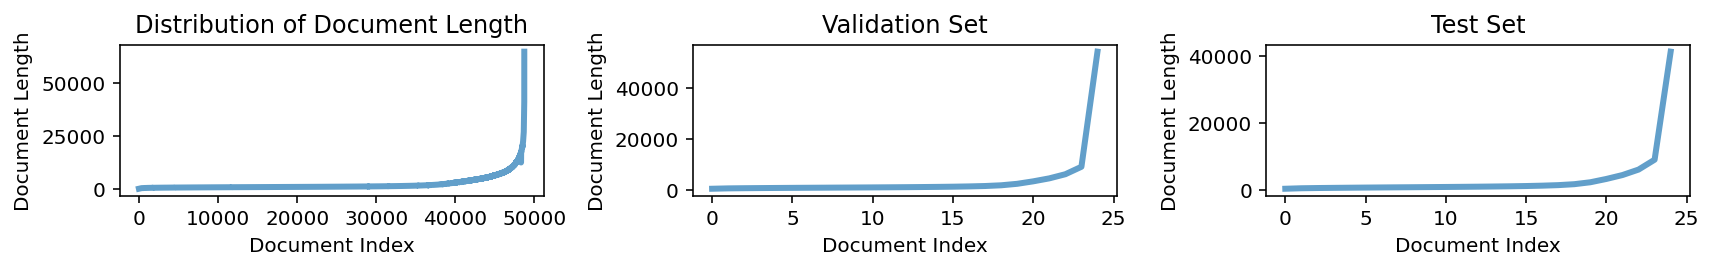

In [4]:
import data

fig = plt.figure(figsize=(12, 2))
plt.subplot(131)
plt.plot([len(src) for fn, src in data.source_gen()], linewidth=3, alpha=.7)
plt.title("Distribution of Document Length")
plt.xlabel('Document Index')
plt.ylabel('Document Length')
plt.subplot(132)
plt.plot([len(src) for fn, src in data.validation_gen()], linewidth=3, alpha=.7)
plt.title("Validation Set")
plt.xlabel('Document Index')
plt.ylabel('Document Length')
plt.subplot(133)
plt.plot([len(src) for fn, src in data.test_gen()], linewidth=3, alpha=.7)
plt.title("Test Set")
plt.xlabel('Document Index')
plt.ylabel('Document Length')

plt.tight_layout()

plt.show()

In [5]:
from tqdm import tqdm
from IPython.display import HTML

def get_chars():
    step = 0
    freq = {}
    keys = []
    for file_name, source in tqdm(data.source_gen()):

        for char in source:
            try:
                freq[char] += 1
            except KeyError:
                freq[char] = 1
                keys.append(char)
    
    return keys, freq
ks, freqs = get_chars()
HTML("<pre style='border: 1px solid #919191;border-radius:10px;background-color:#e4e4e4;padding:10px'>" + "".join(ks) + "</pre>")

48716it [00:07, 6213.11it/s]


### Character Frequency

There is a long tail of characters that appears only once, mostly emoji's and CJK characters. 

In this project, we will just manually specify lowercase alphabets and numbers as our input domain (plus space and carriage return).

 etoainsrlhdcupmgfwyb,v.k-
'STA0P1MICxD2"BWEGN3OHRLFV5)(4Uzj9:q	867$X/KJY?;QZ[]&!–®™*%+=•_#·@£\ €—é¥’{}‐ü|>~α×°à￼©^�―”ö　“<●…ー℠ó§ñ‟±­◦・ッ、：µ‖


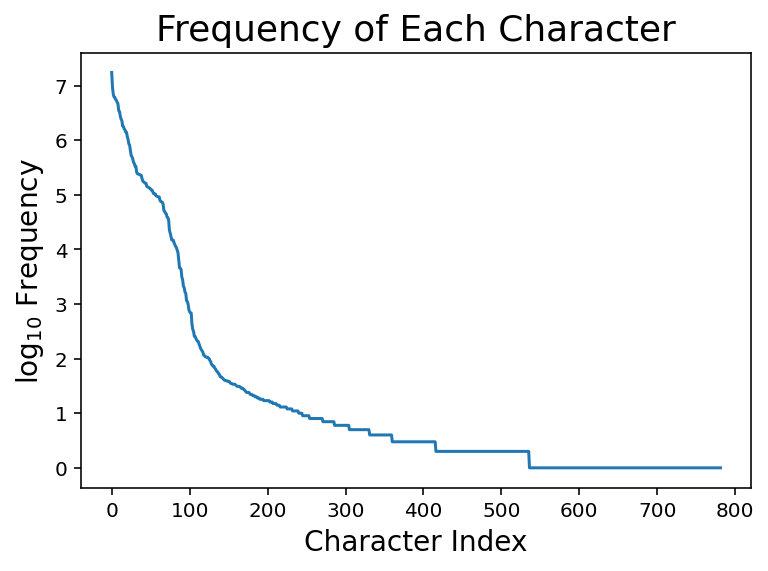

In [6]:
import math, numpy as np, matplotlib.pyplot as plt

order = np.argsort([freqs[k] for k in ks])[::-1]
chars_ordered = "".join(np.array([k for k in ks])[order])
print(chars_ordered[:140])

plt.title('Frequency of Each Character', fontsize=18)
plt.plot(np.array([math.log10(freqs[k]) for k in ks])[order])
plt.ylabel('$\log_{10}$ Frequency', fontsize=14)
plt.xlabel('Character Index', fontsize=14)
plt.show()

### Input Domain

Input domain is [A-z0-9], plus space and new-line "\n" characters. I have considered `"-"` but decided not to add it. 

In speech recognition tasks, we might be able to distinguish between <kbd>space</kbd> and <kbd>⏎</kbd> by the length of the pause.

### Output Domain

The output domain includes the following. The punctuation extraction made sure that strings like "I'm a boy" doesn't introduce conflict between the capitalization of the "i" and the single quote afterward.

```
capitalization: <cap>
         comma:  ,
        period:  .
   dollar sign:  $
     semicolon:  ;
         colon:  :
  single quote:  '
  double quote:  "
  no operation: <nop>
```

In [7]:
input_chars = list(" \nabcdefghijklmnopqrstuvwxyz01234567890")
output_chars = ["<nop>", "<cap>"] + list(".,;:?!\"'$")

### Data Module

Besides loaders for the training data, the data module also contains helper functions such as `extract_punc` and `apply_punc`. Here is an example of what they do:

In [8]:
import data

i, o = data.extract_punc("ATI'd. I'm not sure if $10 is enough. ", input_chars, output_chars)
print("Punc-less Text:\n========================\n", i)
print("\nPunctuation Operators Extracted:\n========================\n", o)
result = data.apply_punc("".join(i), o)
print("\nVarify that it works by recovering the original string:\n========================\n", result)

Punc-less Text:
 ['a', 't', 'i', 'd', ' ', 'i', 'm', ' ', 'n', 'o', 't', ' ', 's', 'u', 'r', 'e', ' ', 'i', 'f', ' ', '1', '0', ' ', 'i', 's', ' ', 'e', 'n', 'o', 'u', 'g', 'h', ' ']

Punctuation Operators Extracted:
 ['<cap>', '<cap>', '<cap>', "'", '.', '<cap>', "'", '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '$', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '<nop>', '.']

Varify that it works by recovering the original string:
 ATI'd. I'm not sure if $10 is enough. 


### Accuracy Metric

The accuracy metric is the standard precision/recall plus F-score. The implementation can be found in script [metric.py](metric.py), referenced from wikipedia and two other papers.

In [9]:
import metric

Key: <nop>	Prec:  99.1%	Recall:  96.6%	F-Score:  97.9%
Key:   ,	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
Key: <cap>	Prec: 100.0%	Recall:  75.0%	F-Score:  85.7%
Key:   .	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
Key:   '	Prec:  66.7%	Recall: 100.0%	F-Score:  80.0%


true_p:	{'<nop>': 114, '<cap>': 3, "'": 2}
p:	{'<nop>': 118, '<cap>': 4, "'": 2}
all_p:	{'<nop>': 115, ',': 2, '<cap>': 3, '.': 1, "'": 3}


### Report Progress Via Visdom

To use visdom, refer to doc and run server
```sh
python visdom.server
```

In [10]:
# # https://github.com/facebookresearch/visdom#setup
# import visdom
# vis = visdom.Visdom()
# vis.env = "deep-punc-experiment"

# emb = None
# opt = None
# smx = None
# lss = None
# def plot_progress(embeded, output, softmax, losses):
#     global emb, opt, smx, lss
#     emb = vis.heatmap(embeded, win=emb or None, opts=dict(title="Input Embedding"))
#     opt = vis.heatmap(output, win=opt or None, opts=dict(title="GRU Output"))
#     smx = vis.heatmap(softmax, win=smx or None, opts=dict(title="Softmax Activation"))
#     lss = vis.line(Y=losses, win=lss or None, opts=dict(title="Loss"))

In [11]:
import utils, data, metric, model
from tqdm import tqdm
import numpy as np
from IPython.display import HTML, clear_output
from termcolor import cprint, colored as c

input_chars = list(" \nabcdefghijklmnopqrstuvwxyz01234567890")
output_chars = ["<nop>", "<cap>"] + list(".,;:?!\"'$")

# torch.set_num_threads(8)
batch_size = 128

char2vec = utils.Char2Vec(chars=input_chars, add_unknown=True)
output_char2vec = utils.Char2Vec(chars = output_chars)
input_size = char2vec.size
output_size = output_char2vec.size

cprint("input_size is: " + c(input_size, 'green') + "; ouput_size is: " + c(output_size, 'green'))
hidden_size = input_size
layers = 1

rnn = model.GruRNN(input_size, hidden_size, output_size, batch_size=batch_size, layers=layers, bi=True)
egdt = model.Engadget(rnn, char2vec, output_char2vec)

input_size is: 40; ouput_size is: 11
****** Engadget Model Initialize ******


**Pre-trained model**: run the cell below (after uncomment) to load the pre-trained model

In [12]:
egdt.load('./data/Gru_Engadget_epch-24.tar')

## Training

The training below initializes the hidden layer at the beginning of each file. I believe this makes it more consistent, and easier for the network to converge.

In [ ]:
learning_rate = 0.5e-4
egdt.setup_training(learning_rate)

seq_length = 500

for epoch_num in range(24, 48):
    
    
    for batch_ind, (max_len, sources) in enumerate(tqdm(data.batch_gen(data.train_gen(), batch_size))):
        
        # prepare the input and output chunks
        input_srcs = []; punc_targs = []
        for chunk in sources:
            input_source, punctuation_target = data.extract_punc(chunk, egdt.char2vec.chars, egdt.output_char2vec.chars)
            input_srcs.append(input_source)
            punc_targs.append(punctuation_target)        
        
        # at the begining of the file, reset hidden to zero
        egdt.init_hidden_(random=False)
        seq_len = data.fuzzy_chunk_len(max_len, seq_length)
        for input_, target_ in zip(zip(*[data.chunk_gen(seq_len, src) for src in input_srcs]), 
                                   zip(*[data.chunk_gen(seq_len, tar, ["<nop>"]) for tar in punc_targs])):
            
            try:
                egdt.forward(input_, target_)
                egdt.descent()
                    
            except KeyError:
                print(source)
                raise KeyError
        
        if batch_ind%25 == 24:
            if batch_ind%100 == 99:
                clear_output(wait=True)
            
            print('Epoch {:d} Batch {}'.format(epoch_num + 1, batch_ind + 1))
            print("=================================")
            punctuation_output = egdt.output_chars()
#             plot_progress(egdt.embeded[0,:400].data.numpy().T, 
#                           egdt.output[0,:400].data.numpy().T, 
#                           egdt.softmax[0,:400].data.numpy().T,
#                           np.array(egdt.losses))

            metric.print_pc(utils.flatten(punctuation_output), utils.flatten(target_) )
            print('\n')
            
        if batch_ind%100 == 99:
            
            validate_target = data.apply_punc(input_[0], target_[0])
            result = data.apply_punc(input_[0], 
                                     punctuation_output[0] )
            print(validate_target)
            print(result)
            
    # print('Dev Set Performance {:d}'.format(epoch_num))
    egdt.save('./data/engadget_train_epoch-{}_batch-{}.tar'.format(epoch_num + 1, batch_ind + 1))

100it [00:57,  1.36it/s]

Epoch 25 Batch 100
Key: <nop>	Prec:  97.5%	Recall:  97.6%	F-Score:  97.6%
Key: <cap>	Prec:  64.9%	Recall:  63.1%	F-Score:  64.0%
Key:   ,	Prec:  35.3%	Recall:  36.8%	F-Score:  36.0%
Key:   '	Prec:  78.9%	Recall:  78.3%	F-Score:  78.6%
Key:   $	Prec:  55.9%	Recall:  50.7%	F-Score:  53.1%
Key:   ?	Prec:   4.4%	Recall:   4.2%	F-Score:   4.3%
Key:   "	Prec:  18.6%	Recall:  28.6%	F-Score:  22.5%
Key:   .	Prec:  38.2%	Recall:  38.1%	F-Score:  38.1%
Key:   !	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A
Key:   :	Prec:  11.8%	Recall:   5.4%	F-Score:   7.4%
Key:   ;	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A



 
Sure, you've bought every console since the original NES, monitor forum threads religiously for any Wii bashing, and may even have a Koopa tattoo somewhere on your body, but are you enough of a fanboy to pay $500 for firstgeneration Nintendo DS emblazoned with a wireframe cartoon dinosaur? Well apparently eBayer "joedick" is one such individual, whose $480 BuyItNowdollars earned him one o

125it [01:16,  1.21it/s]

Epoch 25 Batch 125
Key: <nop>	Prec:  97.6%	Recall:  97.7%	F-Score:  97.6%
Key: <cap>	Prec:  63.0%	Recall:  62.0%	F-Score:  62.5%
Key:   .	Prec:  38.0%	Recall:  34.7%	F-Score:  36.3%
Key:   '	Prec:  80.7%	Recall:  84.3%	F-Score:  82.4%
Key:   "	Prec:  12.6%	Recall:  19.1%	F-Score:  15.2%
Key:   ,	Prec:  34.1%	Recall:  36.0%	F-Score:  35.0%
Key:   $	Prec:  50.9%	Recall:  43.8%	F-Score:  47.1%
Key:   ?	Prec:   1.9%	Recall:   2.7%	F-Score:   2.2%
Key:   :	Prec:  17.1%	Recall:   7.7%	F-Score:  10.6%
Key:   ;	Prec:   9.1%	Recall:   8.3%	F-Score:   8.7%
Key:   !	Prec:   0.0%	Recall:   0.0%	F-Score:   N/A




149it [01:36,  1.19it/s]

Let's take a look at the performance!

In [ ]:
egdt.save('./data/Gru_Engadget_epch-48.tar')

In [ ]:
print('Epoch {:d} Batch {} Training P/R'.format(epoch_num + 1, batch_ind + 1))
print("=================================")
punctuation_output = egdt.output_chars()
_ = metric.print_pc(utils.flatten(punctuation_output), utils.flatten(target_) )

## Performance

Here is the performance after 24 and 48 epochs of training. 

In [ ]:
punc_outputs = []
punc_targets = []
for fn, source in tqdm(data.test_gen()):
    input_text, punc_target = data.extract_punc(source, input_chars, output_chars)
    egdt.model.batch_size = 1
    egdt.init_hidden_()
    egdt.next_([input_text])
    punc_outputs.append(egdt.output_chars()[0])
    punc_targets.append(punc_target)
    
print('Test P/R  Epoch {:d} Batch {}'.format(epoch_num + 1, batch_ind + 1))
print("=================================")    
_ = metric.print_pc(utils.flatten(punc_outputs), utils.flatten(punc_targets))

In [ ]:
punc_outputs = []
punc_targets = []
for fn, source in tqdm(data.test_gen()):
    input_text, punc_target = data.extract_punc(source, input_chars, output_chars)
    egdt.model.batch_size = 1
    egdt.init_hidden_()
    egdt.next_([input_text])
    punc_outputs.append(egdt.output_chars()[0])
    punc_targets.append(punc_target)
    
print('Test P/R  Epoch {:d} Batch {}'.format(epoch_num + 1, batch_ind + 1))
print("=================================")    
_ = metric.print_pc(utils.flatten(punc_outputs), utils.flatten(punc_targets))

## Now A LIVE Demo using the network to add punctuations to your input! (need to execute this notebook)

Run these cells below after training. alternatively, uncomment the cell below to load pre-trained parameters.

In [ ]:
from ipywidgets import widgets
from IPython.display import display, clear_output

In [ ]:
# egdt.load('./data/Gru_Engadget_epch-48.tar')

**Note**: Again, using a zero initial state for the hidden state gives a much better result for the prediction.

In [ ]:
def predict_next(source, gen_length=None, temperature=0.05):
    global epoch_num
    global batch_ind
    
    input_text, punc_target = data.extract_punc(source, input_chars, output_chars)
    egdt.model.batch_size = 1
    egdt.init_hidden_()
    egdt.next_([input_text])
    punc_output = egdt.output_chars(temperature=temperature)[0]
    result = data.apply_punc(input_text, punc_output)
    
    clear_output()
    print('Demo P/R (Epoch {:d} Batch {} )'.format(epoch_num + 1, batch_ind + 1))
    print("=================================")    
    _ = metric.print_pc(punc_output, punc_target)
    print("\n" + result)

predict_next("This won't be a simple sentense. It doesnt have puntuations\n\nI'm not sure. ", 200, 1)

In [ ]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    #print(text_input.value)
    predict_next(text_input.value, 2000, temperature=1)

print("Type in a sentence with punctuations just as you would normally have!\nThe demo will strip off those punctuations, and try to predict them.")

text_input.on_submit(handle_submit)

The demo looks pretty good ;-) 